In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [62]:
df = pd.read_parquet("https://github.com/ALEYI17/gpu_test_infrasight/raw/refs/heads/main/final_gpu_time_windows.parquet")
df.groupby(["app_name", "label"]).size()
df.head()

,pid,comm,uid,gid,ppid,user_pid,user_ppid,cgroup_id,cgroup_name,user,...,memcpy_rate,alloc_rate,wall_time_dt,wall_time_ms,container_id,container_image,container_labels_json,app_name,label,experiment_time
0,64666,hashcat,0,0,0,0,0,0,,,...,4.0,0.0,2025-11-11 22:31:33.200000+00:00,1762900293200,,,{},passwd_hashcat,1,20251111T222850Z
1,64666,hashcat,0,0,0,0,0,0,,,...,0.0,0.0,2025-11-11 22:31:36.994000+00:00,1762900296994,,,{},passwd_hashcat,1,20251111T222850Z
2,64417,hashcat,0,0,0,0,0,0,,,...,13.0,14.5,2025-11-11 22:28:41.469000+00:00,1762900121469,,,{},passwd_hashcat,1,20251111T222850Z
3,64443,hashcat,0,0,0,0,0,0,,,...,13.0,14.5,2025-11-11 22:28:45.610000+00:00,1762900125610,,,{},passwd_hashcat,1,20251111T222850Z
4,64469,hashcat,0,0,0,0,0,0,,,...,13.0,14.5,2025-11-11 22:28:48.582000+00:00,1762900128582,,,{},passwd_hashcat,1,20251111T222850Z


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2946 entries, 0 to 2945
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   pid                     2946 non-null   uint32             
 1   comm                    2946 non-null   object             
 2   uid                     2946 non-null   uint32             
 3   gid                     2946 non-null   uint32             
 4   ppid                    2946 non-null   uint32             
 5   user_pid                2946 non-null   uint32             
 6   user_ppid               2946 non-null   uint32             
 7   cgroup_id               2946 non-null   uint64             
 8   cgroup_name             2946 non-null   object             
 9   user                    2946 non-null   object             
 10  window_start_ns         2946 non-null   int64              
 11  window_end_ns           2946 non-null   int

In [64]:
df.isna().sum()

pid                       0
comm                      0
uid                       0
gid                       0
ppid                      0
user_pid                  0
user_ppid                 0
cgroup_id                 0
cgroup_name               0
user                      0
window_start_ns           0
window_end_ns             0
kernel_launch_count       0
mem_alloc_count           0
memcpy_count              0
stream_sync_count         0
avg_threads_per_kernel    0
max_threads_per_kernel    0
avg_blocks_per_kernel     0
total_threads_launched    0
total_mem_alloc_bytes     0
avg_mem_alloc_bytes       0
total_memcpy_bytes        0
avg_memcpy_bytes          0
htod_bytes                0
dtoh_bytes                0
htod_ratio                0
avg_sync_time_ns          0
max_sync_time_ns          0
sync_fraction             0
launch_rate               0
memcpy_rate               0
alloc_rate                0
wall_time_dt              0
wall_time_ms              0
container_id        

In [65]:
counts = df["label"].value_counts()
print(counts)

# Or more descriptive:
print("Benign (0):", counts.get(0, 0))
print("Malign (1):", counts.get(1, 0))
print("Total:", len(df))

label
0    1811
1    1135
Name: count, dtype: int64
Benign (0): 1811
Malign (1): 1135
Total: 2946


In [66]:
counts = df["app_name"].value_counts()
print(counts)

app_name
llm_gpt_neo       754
miner_xmrig       679
passwd_hashcat    456
ml_svm            241
llm_gpt           190
llm_bert          132
dl_lstm_train     131
dl_cnn_train      109
blender            98
llm_roberta        85
ml_logreg          46
ml_forest          25
Name: count, dtype: int64


In [67]:
df["experiment_id"] = df["app_name"].astype(str) + "_" + df["experiment_time"].astype(str)

In [68]:
drop_cols = [
    "pid", "uid", "gid", "ppid", "user_pid", "user_ppid",
    "cgroup_id", "cgroup_name", "user",
    "container_id", "container_image", "container_labels_json",
    "experiment_time", "wall_time_dt", "wall_time_ms", "window_start_ns", "window_end_ns"
]
df = df.drop(columns=drop_cols, errors="ignore")


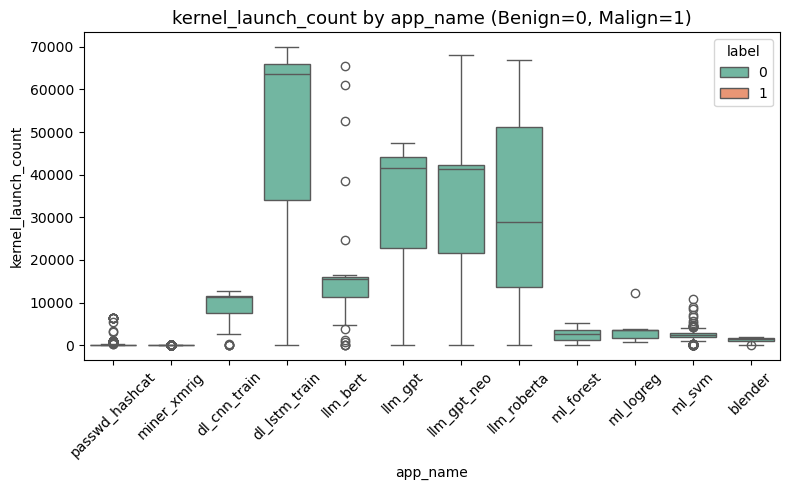

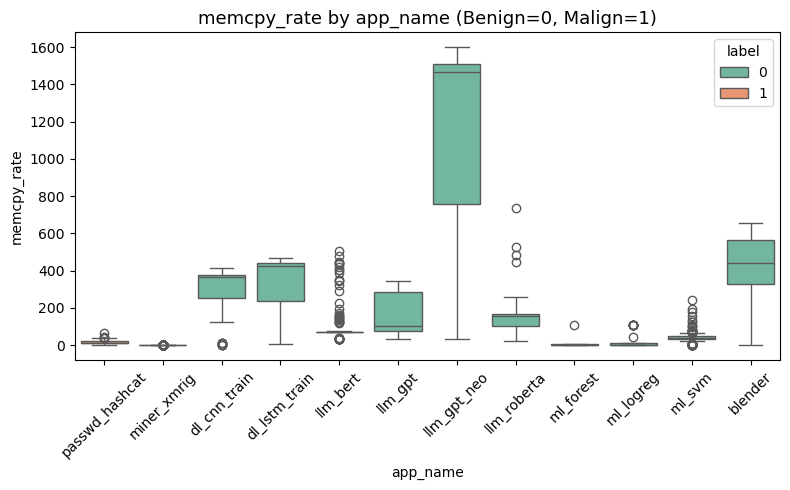

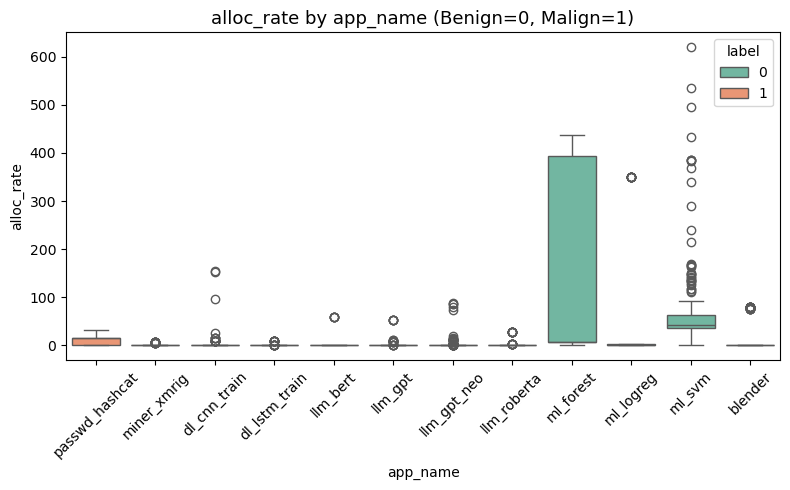

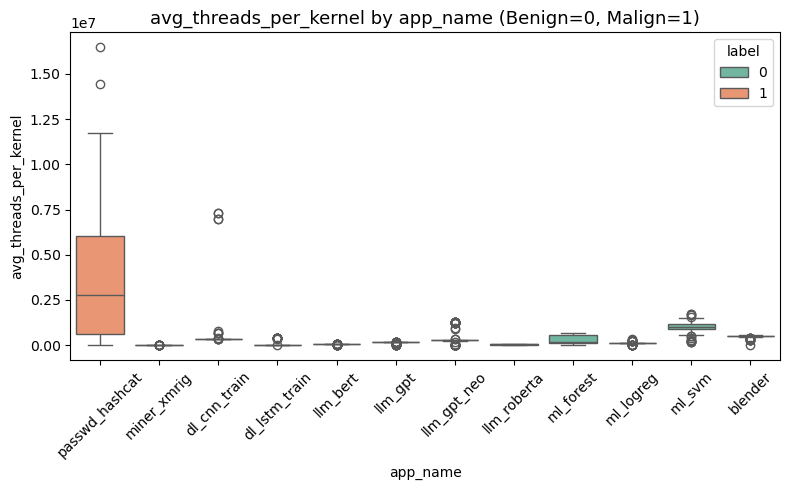

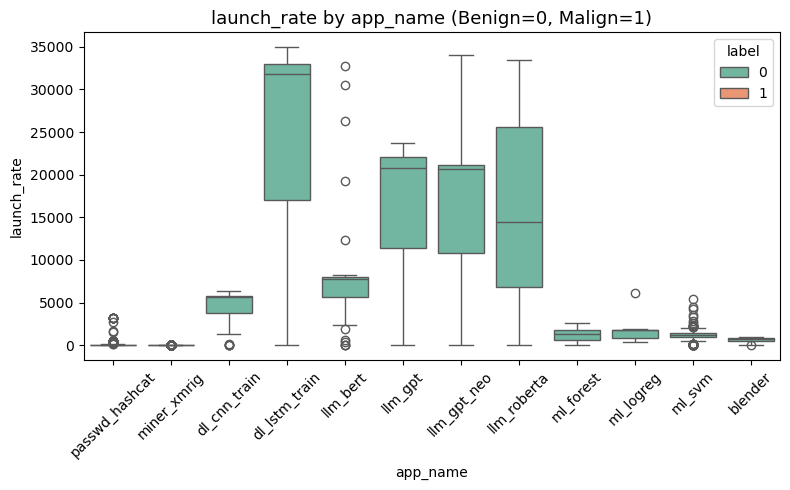

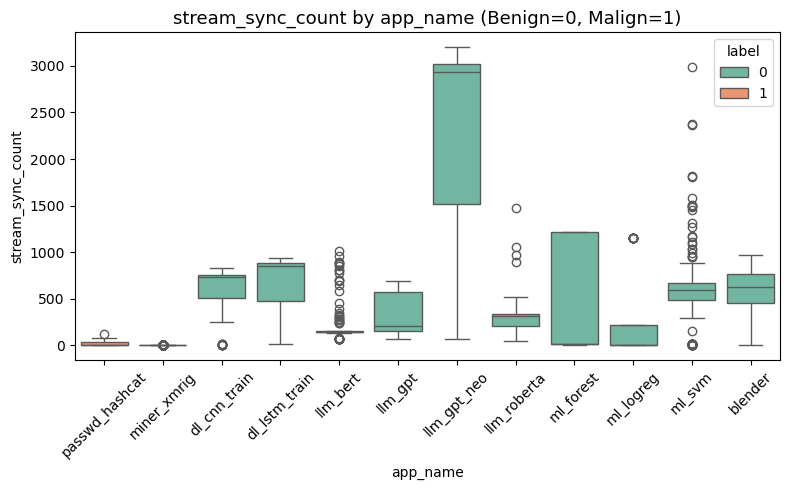

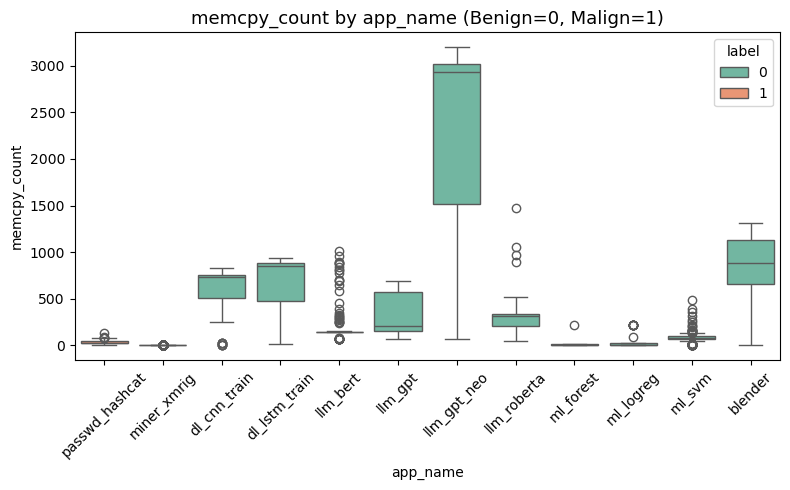

In [69]:
numeric_features = df.select_dtypes(include=["float64", "int64", "uint64", "uint32"]).columns
top_feats = ["kernel_launch_count", "memcpy_rate", "alloc_rate", "avg_threads_per_kernel", "launch_rate","stream_sync_count", "memcpy_count"]

for feat in top_feats:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="app_name", y=feat, hue="label", palette="Set2")
    plt.title(f"{feat} by app_name (Benign=0, Malign=1)", fontsize=13)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

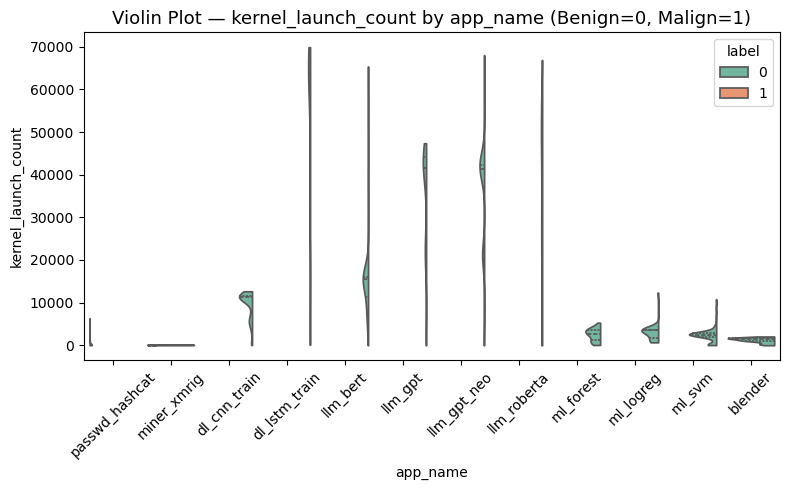

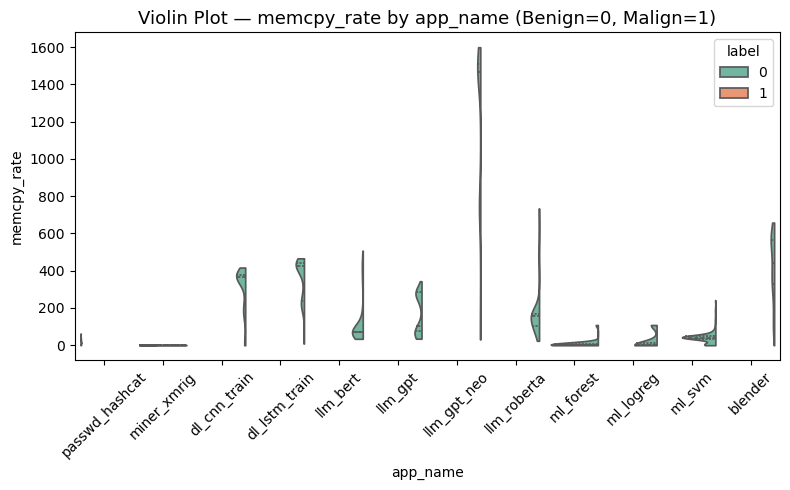

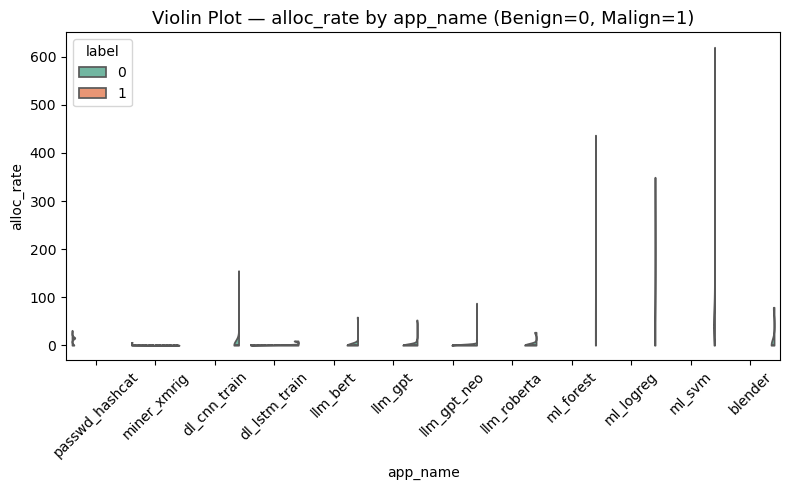

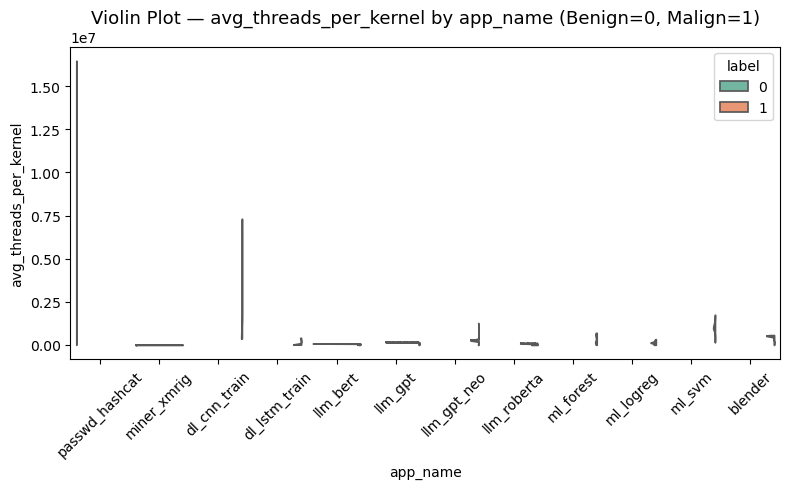

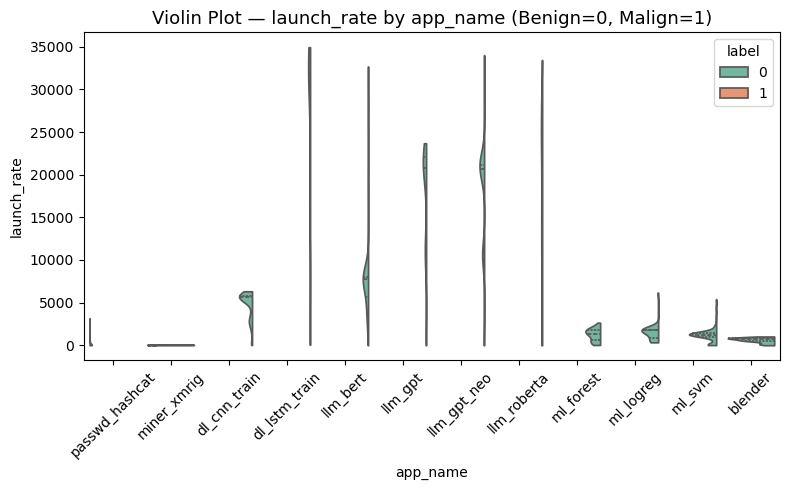

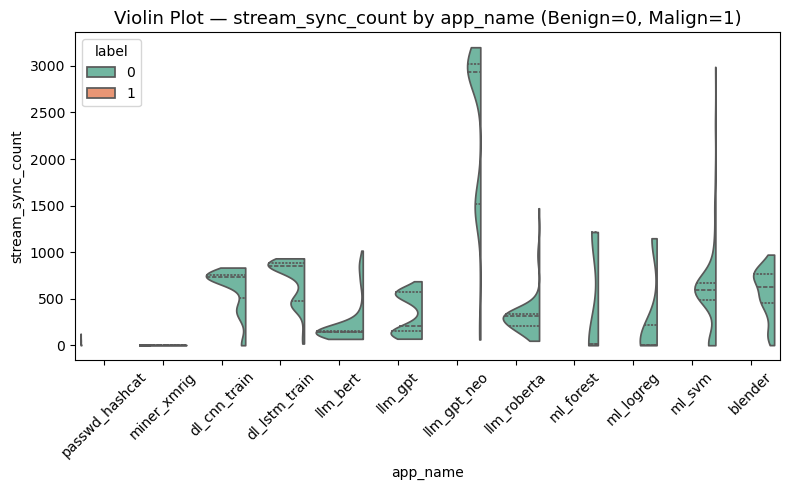

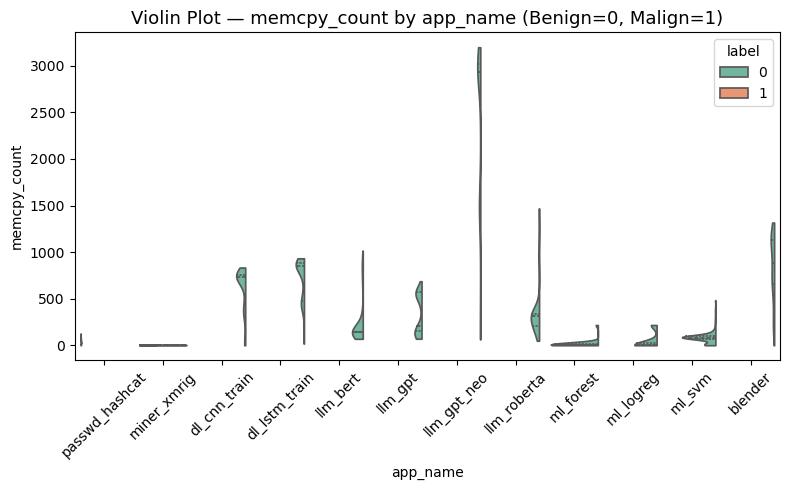

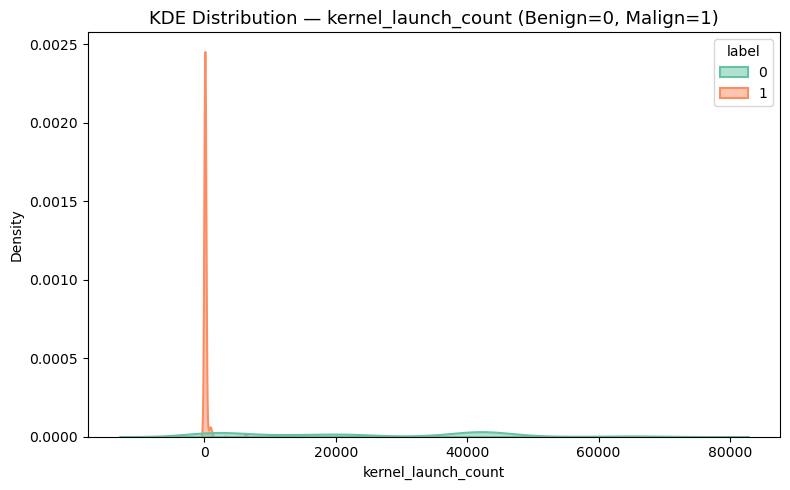

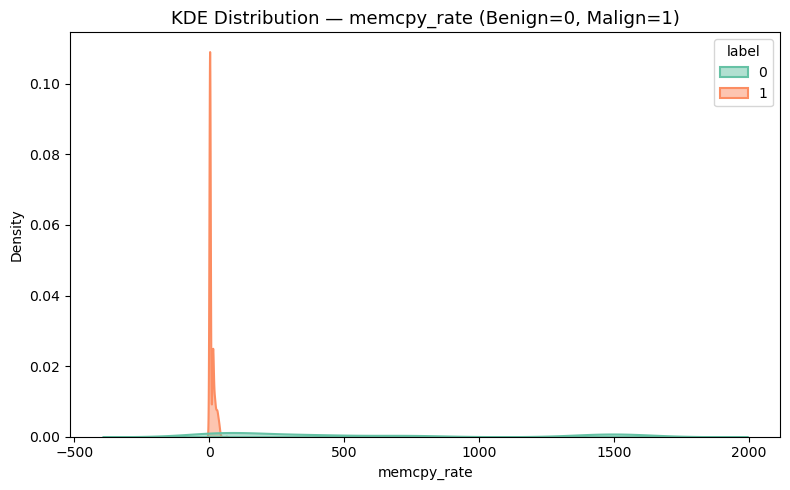

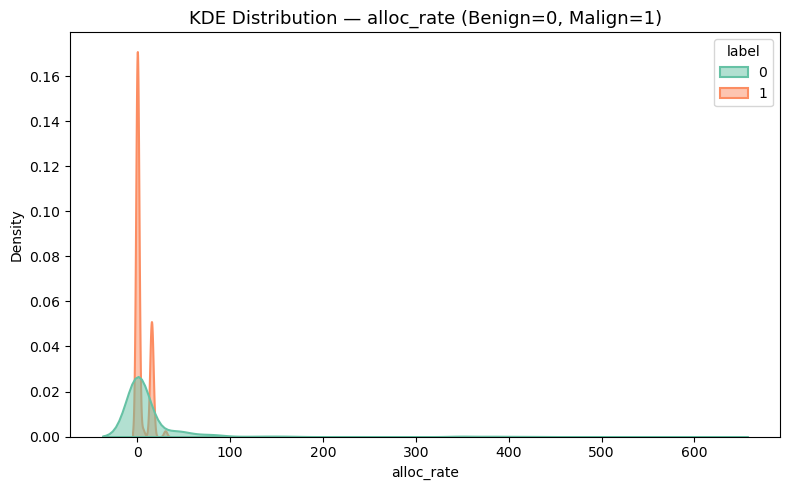

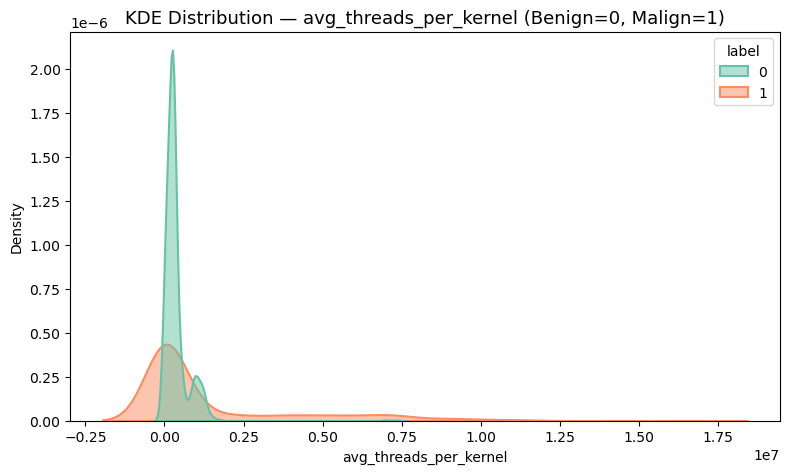

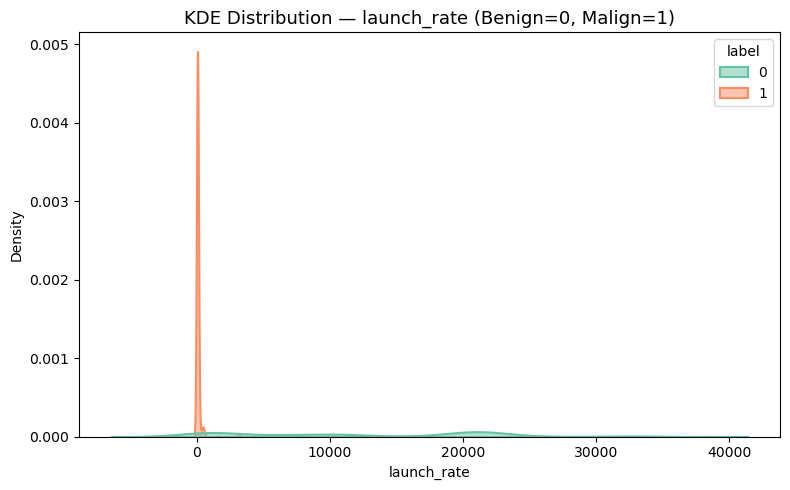

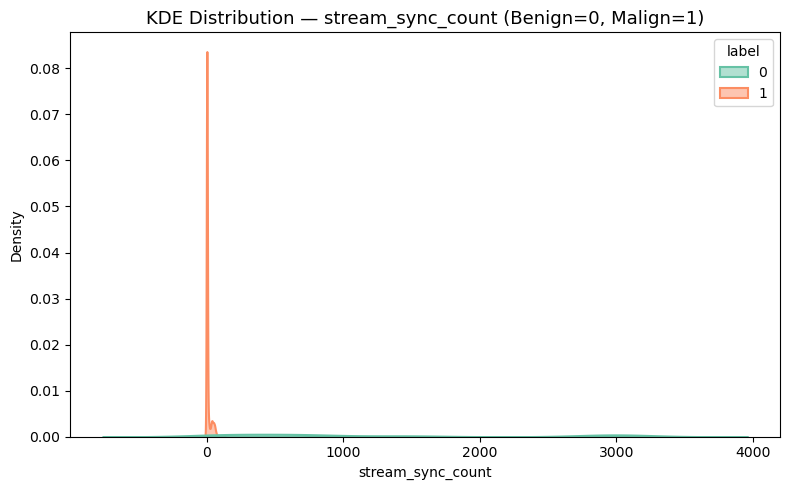

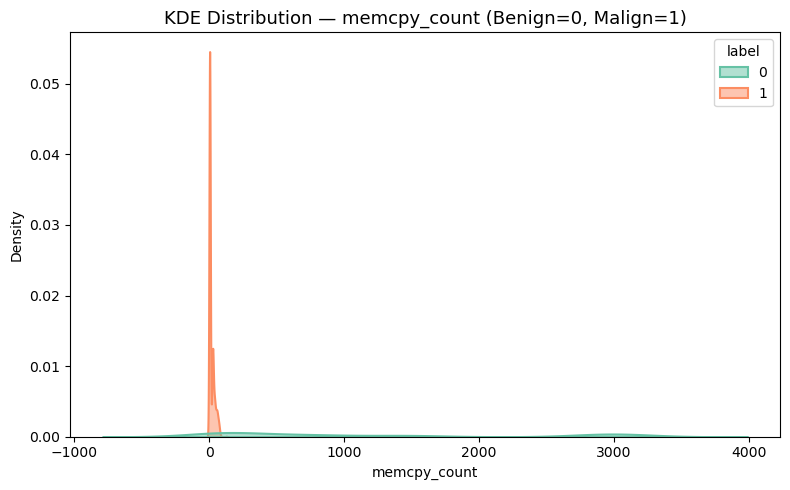

In [70]:
for feat in top_feats:
    plt.figure(figsize=(8, 5))
    sns.violinplot(
        data=df,
        x="app_name",
        y=feat,
        hue="label",
        split=True,          # combines both classes side by side
        inner="quart",       # shows quartiles inside
        palette="Set2",
        cut=0
    )
    plt.title(f"Violin Plot — {feat} by app_name (Benign=0, Malign=1)", fontsize=13)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


for feat in top_feats:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(
        data=df,
        x=feat,
        hue="label",
        fill=True,
        common_norm=False,
        alpha=0.5,
        linewidth=1.5,
        palette="Set2"
    )
    plt.title(f"KDE Distribution — {feat} (Benign=0, Malign=1)", fontsize=13)
    plt.xlabel(feat)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

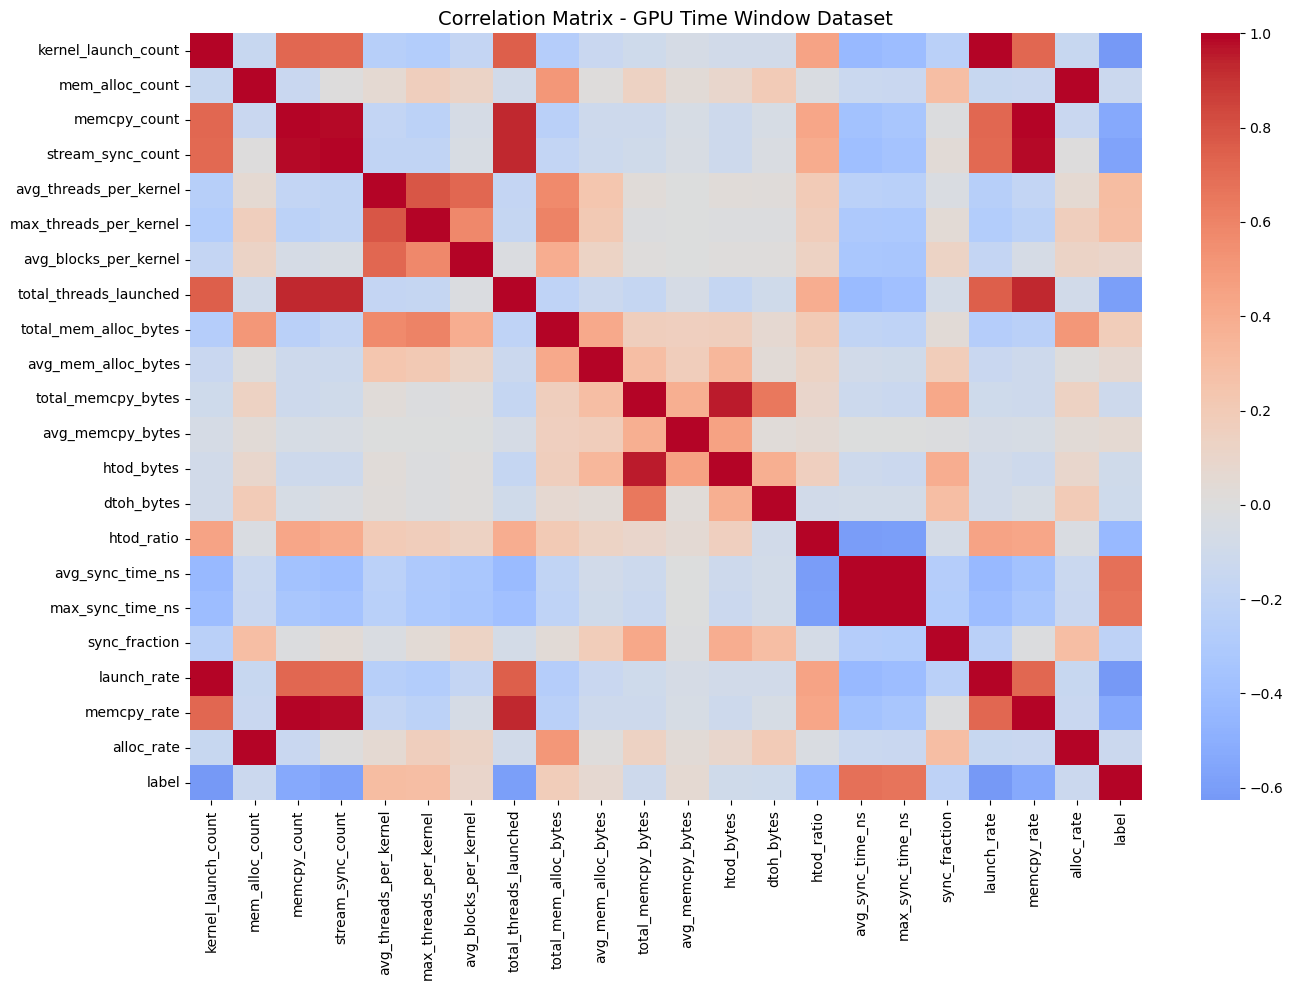

In [71]:
plt.figure(figsize=(14, 10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix - GPU Time Window Dataset", fontsize=14)
plt.tight_layout()
plt.show()

In [72]:
X = df.drop(columns=["label", "app_name", "comm", "experiment_id", "label"])
y = df["label"]
groups = df["experiment_id"]

In [73]:
        scaler = StandardScaler()
        num_cols = X.select_dtypes(include=["float64", "int64", "uint64", "uint32"]).columns
        X[num_cols] = scaler.fit_transform(X[num_cols])

In [74]:
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=42, stratify=y
#)

In [75]:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in gss.split(X, y, groups):
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_test = y.iloc[test_idx]
    print("Train size:", len(X_train))
    print("Test size :", len(X_test))

Train size: 2475
Test size : 471


In [76]:
rf = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

,n_estimators,150
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [77]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

acc = rf.score(X_test, y_test)
auc = roc_auc_score(y_test, y_prob)

print("\n=== RESULTS ===")
print(f"Accuracy : {acc:.4f}")
print(f"AUC      : {auc:.4f}")
print(classification_report(y_test, y_pred))


=== RESULTS ===
Accuracy : 0.9958
AUC      : 1.0000
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       392
           1       0.98      1.00      0.99        79

    accuracy                           1.00       471
   macro avg       0.99      1.00      0.99       471
weighted avg       1.00      1.00      1.00       471



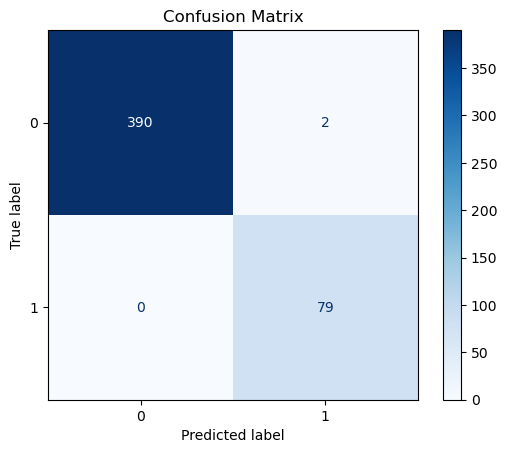

In [78]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

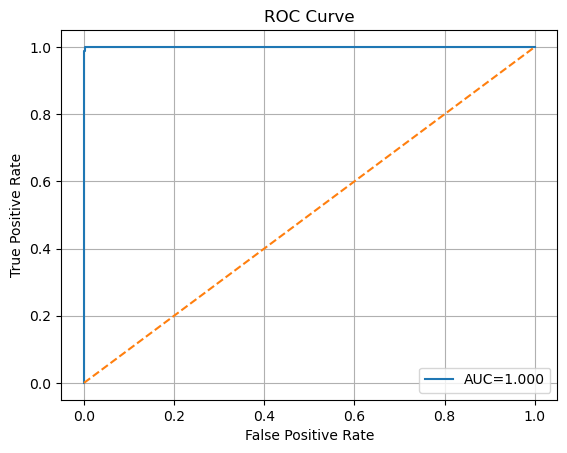

In [79]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


/tmp/ipykernel_24477/3454486322.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=importances.index[:20], x=importances.values[:20], palette="viridis")


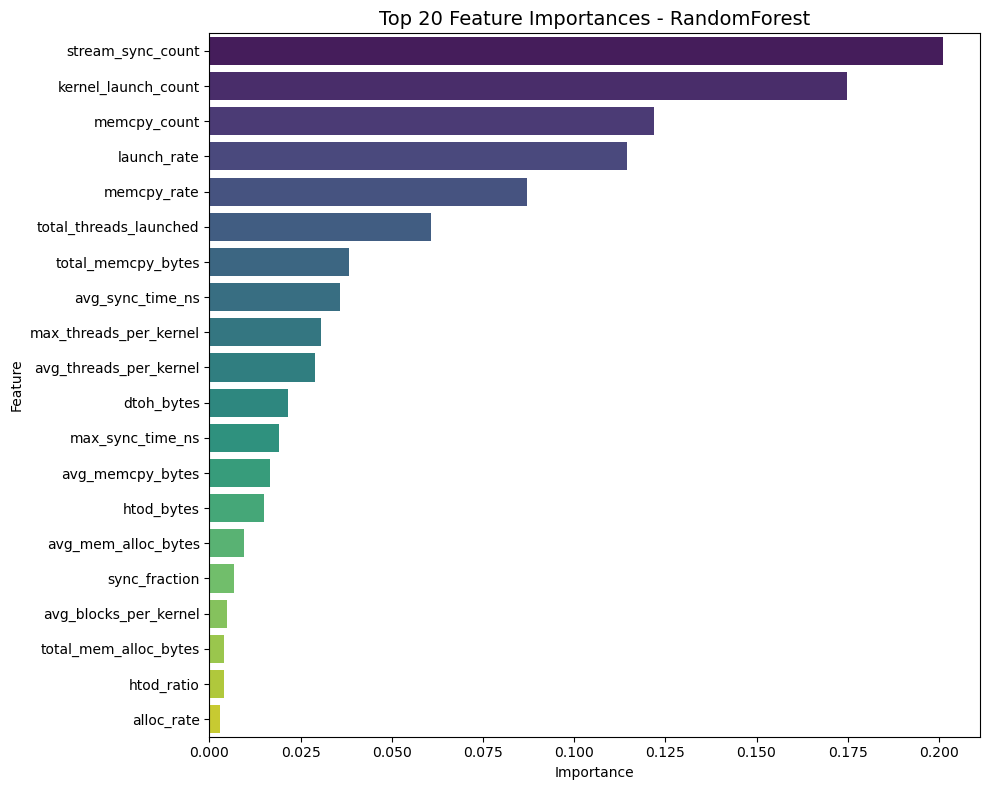

In [80]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(y=importances.index[:20], x=importances.values[:20], palette="viridis")
plt.title("Top 20 Feature Importances - RandomForest", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [81]:
fi = pd.Series(rf.feature_importances_, index=X_train.columns)
fi.sort_values(ascending=False).head(20)

stream_sync_count         0.201200
kernel_launch_count       0.174888
memcpy_count              0.121792
launch_rate               0.114385
memcpy_rate               0.087077
total_threads_launched    0.060772
total_memcpy_bytes        0.038230
avg_sync_time_ns          0.035724
max_threads_per_kernel    0.030676
avg_threads_per_kernel    0.029001
dtoh_bytes                0.021566
max_sync_time_ns          0.019000
avg_memcpy_bytes          0.016503
htod_bytes                0.014963
avg_mem_alloc_bytes       0.009588
sync_fraction             0.006855
avg_blocks_per_kernel     0.004926
total_mem_alloc_bytes     0.003890
htod_ratio                0.003885
alloc_rate                0.002813
dtype: float64

In [82]:
df_test = pd.read_parquet("https://github.com/ALEYI17/gpu_test_infrasight/raw/refs/heads/main/dataset_test/lolminer/audit_gpu_time_window_events.parquet")
df_test.groupby(["comm"]).size()
df_test.head()

,pid,comm,uid,gid,ppid,user_pid,user_ppid,cgroup_id,cgroup_name,user,...,max_sync_time_ns,sync_fraction,launch_rate,memcpy_rate,alloc_rate,wall_time_dt,wall_time_ms,container_id,container_image,container_labels_json
0,64281,lolMiner,0,0,0,0,0,0,,,...,701359,0.083333,0.5,3.5,1.5,2025-11-14 23:12:44.177000+00:00,1763161964177,,,{}
1,64281,lolMiner,0,0,0,0,0,0,,,...,253781866,0.500000,8.0,0.0,0.0,2025-11-14 23:12:48.063000+00:00,1763161968063,,,{}
2,64281,lolMiner,0,0,0,0,0,0,,,...,251633235,0.500000,8.0,0.0,0.0,2025-11-14 23:12:52.087000+00:00,1763161972087,,,{}
3,64281,lolMiner,0,0,0,0,0,0,,,...,247596961,0.208333,8.0,1.5,0.0,2025-11-14 23:12:56.026000+00:00,1763161976026,,,{}
4,64281,lolMiner,0,0,0,0,0,0,,,...,0,0.000000,7.0,0.0,0.0,2025-11-14 23:13:00.153000+00:00,1763161980153,,,{}


In [83]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   pid                     45 non-null     uint32             
 1   comm                    45 non-null     object             
 2   uid                     45 non-null     uint32             
 3   gid                     45 non-null     uint32             
 4   ppid                    45 non-null     uint32             
 5   user_pid                45 non-null     uint32             
 6   user_ppid               45 non-null     uint32             
 7   cgroup_id               45 non-null     uint64             
 8   cgroup_name             45 non-null     object             
 9   user                    45 non-null     object             
 10  window_start_ns         45 non-null     int64              
 11  window_end_ns           45 non-null     int64  

In [84]:
drop_cols = [
    "pid", "uid", "gid", "ppid", "user_pid", "user_ppid",
    "cgroup_id", "cgroup_name", "user",
    "container_id", "container_image", "container_labels_json",
    "experiment_time", "wall_time_dt", "wall_time_ms",
    "window_start_ns", "window_end_ns",
]

df_test_clean = df_test.drop(columns=drop_cols, errors="ignore")

In [85]:
train_features = X_train.columns
df_test_clean = df_test_clean[train_features]
df_test_clean[num_cols] = scaler.transform(df_test_clean[num_cols])


In [86]:
test_pred = rf.predict(df_test_clean)
test_prob = rf.predict_proba(df_test_clean)[:, 1]

print("Predictions:", test_pred)
print("Probabilities:", test_prob)

Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
Probabilities: [0.58       0.70666667 0.70666667 0.82       0.9        0.9
 0.9        0.9        0.9        0.9        0.9        0.9
 0.9        0.9        0.9        0.72666667 0.70666667 0.82
 0.9        0.9        0.9        0.9        0.9        0.9
 0.9        0.9        0.9        0.9        0.9        0.9
 0.72       0.93333333 0.93333333 0.93333333 0.91333333 0.93333333
 0.93333333 0.93333333 0.93333333 0.93333333 0.93333333 0.93333333
 0.93333333 0.93333333 0.93333333]


In [87]:
print("\n=== CONFUSION MATRIX & METRICS ===")

# Since this dataset is 100% malign (label=1)
y_true = np.ones(len(test_pred))
y_pred = test_pred

# Confusion matrix with labels explicitly ordered [0,1]
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(cm)

print(f"\nTN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn}")
print(f"TP: {tp}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# AUC score
try:
    auc = roc_auc_score(y_true, test_prob)
    print(f"AUC: {auc:.4f}")
except:
    print("AUC could not be computed (all labels are the same).")


=== CONFUSION MATRIX & METRICS ===

Confusion Matrix:
[[ 0  0]
 [ 0 45]]

TN: 0
FP: 0
FN: 0
TP: 45

Classification Report:
              precision    recall  f1-score   support

         1.0     1.0000    1.0000    1.0000        45

    accuracy                         1.0000        45
   macro avg     1.0000    1.0000    1.0000        45
weighted avg     1.0000    1.0000    1.0000        45

AUC: nan


/home/aleyi/miniconda3/envs/infrasight-ml/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [88]:
df_test = pd.read_parquet("https://github.com/ALEYI17/gpu_test_infrasight/raw/refs/heads/main/dataset_test/llm_blom/audit_gpu_time_window_events.parquet")
df_test.groupby(["comm"]).size()
df_test.head()



,pid,comm,uid,gid,ppid,user_pid,user_ppid,cgroup_id,cgroup_name,user,...,max_sync_time_ns,sync_fraction,launch_rate,memcpy_rate,alloc_rate,wall_time_dt,wall_time_ms,container_id,container_image,container_labels_json
0,12103,python3,0,0,0,0,0,0,,,...,3676523,0.003247,33343.5,109.0,5.5,2025-11-18 22:26:46.913000+00:00,1763504806913,,,{}
1,12103,python3,0,0,0,0,0,0,,,...,3765152,0.332207,342.0,344.0,5.5,2025-11-18 22:26:43.965000+00:00,1763504803965,,,{}
2,12103,python3,0,0,0,0,0,0,,,...,4199399,0.003117,26144.0,82.0,0.5,2025-11-18 22:26:50.905000+00:00,1763504810905,,,{}
3,11954,python3,0,0,0,0,0,0,,,...,20600823,0.097671,4943.5,608.0,65.5,2025-11-18 22:22:14.600000+00:00,1763504534600,,,{}
4,11954,python3,0,0,0,0,0,0,,,...,30217606,0.054775,32655.5,2009.5,3.0,2025-11-18 22:22:18.104000+00:00,1763504538104,,,{}


In [89]:
    drop_cols = [
        "pid", "uid", "gid", "ppid", "user_pid", "user_ppid",
        "cgroup_id", "cgroup_name", "user",
        "container_id", "container_image", "container_labels_json",
        "experiment_time", "wall_time_dt", "wall_time_ms",
        "window_start_ns", "window_end_ns",
    ]
    
    df_test_clean = df_test.drop(columns=drop_cols, errors="ignore")
    
    train_features = X_train.columns
    df_test_clean = df_test_clean[train_features]
    df_test_clean[num_cols] = scaler.transform(df_test_clean[num_cols])
    
    test_pred = rf.predict(df_test_clean)
    test_prob = rf.predict_proba(df_test_clean)[:, 1]
    
    print("Predictions:", test_pred)
    print("Probabilities:", test_prob)

Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
Probabilities: [0.         0.03333333 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


In [90]:
print("\n=== CONFUSION MATRIX & METRICS (BENIGN DATASET) ===")

# All samples here are BENIGN => true label = 0
y_true = np.zeros(len(test_pred))
y_pred = test_pred

# Confusion matrix with labels ordered 0 (benign), 1 (malign)
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(cm)

print(f"\nTN: {tn}   (correctly predicted benign)")
print(f"FP: {fp}   (WRONGLY predicted malign → false alarm)")
print(f"FN: {fn}   (wrong, but should be impossible here)")
print(f"TP: {tp}   (predicted malign but benign dataset → also should be 0)")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# AUC
try:
    auc = roc_auc_score(y_true, test_prob)
    print(f"AUC: {auc:.4f}")
except:
    print("AUC could not be computed (all labels are the same).")


=== CONFUSION MATRIX & METRICS (BENIGN DATASET) ===

Confusion Matrix:
[[79  0]
 [ 0  0]]

TN: 79   (correctly predicted benign)
FP: 0   (WRONGLY predicted malign → false alarm)
FN: 0   (wrong, but should be impossible here)
TP: 0   (predicted malign but benign dataset → also should be 0)

Classification Report:
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000        79

    accuracy                         1.0000        79
   macro avg     1.0000    1.0000    1.0000        79
weighted avg     1.0000    1.0000    1.0000        79

AUC: nan


/home/aleyi/miniconda3/envs/infrasight-ml/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
